# 迁移学习实现玉米病虫害分类

图片分类与目标检测
- 图片分类：在图像分类任务中，我们假设图像中只有一个主要物体对象，我们只关注如何识别其类别。
- 目标检测：很多时候图像里有多个我们感兴趣的目标，我们不仅想知道它们的类别，还想得到它们在图像中的具体位置。在计算机视觉里，我们将这类任务称为**目标检测**（object detection）或**目标识别**（object recognition）。

## 1. 读取数据集并对其进行预处理


In [2]:
%matplotlib inline
import os
import torch
import torchvision
from torch import nn
from d2l import torch as d2l
import numpy as np
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, auc
import random
import pandas as pd

In [3]:


data_dir=('/media/zhang/Disk0/dataset/d2l/data/corn')

"""
我们创建两个实例来分别读取训练和测试数据集中的所有图像文件。
该数据集包含200张健康玉米叶图片与200张生病的玉米叶图，这里每类选用100张进行训练，剩余100张进行测试

"""


train_path = os.path.join(data_dir, 'train')
test_path = os.path.join(data_dir, 'test')
print('训练集路径', train_path)
print('测试集路径', test_path)


训练集路径 /media/zhang/Disk0/dataset/d2l/data/corn/train
测试集路径 /media/zhang/Disk0/dataset/d2l/data/corn/test


In [4]:
train_imgs=torchvision.datasets.ImageFolder(os.path.join(data_dir,'train'))
test_imgs=torchvision.datasets.ImageFolder(os.path.join(data_dir,'test'))


print('训练集图像数量', len(train_imgs))
print('类别个数', len(train_imgs.classes))
print('各类别名称', train_imgs.classes)

训练集图像数量 500
类别个数 5
各类别名称 ['debanbing', 'healthy', 'wenbaoyebanbing', 'xiubing', 'yuanbanbing']


In [5]:
"""
类别和索引号 一一对应
"""
# 各类别名称
class_names = train_imgs.classes
n_class = len(class_names)
class_names

['debanbing', 'healthy', 'wenbaoyebanbing', 'xiubing', 'yuanbanbing']

In [6]:
# 映射关系：类别 到 索引号
train_imgs.class_to_idx

{'debanbing': 0,
 'healthy': 1,
 'wenbaoyebanbing': 2,
 'xiubing': 3,
 'yuanbanbing': 4}

In [7]:
# 映射关系：索引号 到 类别
idx_to_labels = {y:x for x,y in train_imgs.class_to_idx.items()}
idx_to_labels

{0: 'debanbing',
 1: 'healthy',
 2: 'wenbaoyebanbing',
 3: 'xiubing',
 4: 'yuanbanbing'}

In [8]:
# 保存为本地的 npy 文件
np.save('./idx_to_labels.npy', idx_to_labels)
np.save('./labels_to_idx.npy', train_imgs.class_to_idx)

In [9]:
"""
在训练期间，我们首先从图像中裁切随机大小和随机长宽比的区域，然后将该区域缩放为224x224输入图像。

在测试过程中，我们将图像的高度和宽度都缩放到256像素，然后裁剪中央224x224区域作为输入。

此外，对于RGB（红、绿和蓝）颜色通道，我们分别标准化每个通道。 具体而言，该通道的每个值减去该通道的平均值，然后将结果除以该通道的标准差。
"""

# 使用RGB通道的均值和标准差，以标准化每个通道
normalize=torchvision.transforms.Normalize([0.485,0.456,0.406],
                                           [0.229,0.224,0.225])
train_augs=torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(224),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    normalize])

test_augs=torchvision.transforms.Compose([
    torchvision.transforms.Resize([256,256]),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    normalize])

## 2 定义和初始化模型

In [10]:
"""
我们使用在ImageNet数据集上预训练的ResNet-50作为源模型。在这里，我们指定`pretrained=True`以自动下载预训练的模型参数(参数列表中的pretrained在新版本中被废用了，要使用weights这个参数。)。如果你首次使用此模型，则需要连接互联网才能下载。
"""
pretrained_net=torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)

"""
预训练的源模型实例包含许多特征层和一个输出层fc。 此划分的主要目的是促进对除输出层以外所有层的模型参数进行微调。 下面给出了源模型的成员变量fc。
"""
pretrained_net.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [11]:
"""
目标模型finetune_net中成员变量features的参数被初始化为源模型相应层的模型参数。由于模型参数是在ImageNet数据集上预训练的，并且足够好，因此通常只需要较小的学习率即可微调这些参数。
"""

finetune_net=torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)

finetune_net.fc=nn.Linear(finetune_net.fc.in_features,5)
print(finetune_net.fc)
nn.init.xavier_uniform_(finetune_net.fc.weight)  # 初始化最后全连接层的权重


Linear(in_features=2048, out_features=5, bias=True)


Parameter containing:
tensor([[ 0.0080, -0.0002,  0.0475,  ...,  0.0128, -0.0155, -0.0209],
        [ 0.0212, -0.0523,  0.0412,  ...,  0.0316,  0.0310,  0.0266],
        [-0.0087, -0.0115,  0.0135,  ...,  0.0536,  0.0324, -0.0511],
        [-0.0102, -0.0162, -0.0034,  ...,  0.0436, -0.0218, -0.0119],
        [-0.0090,  0.0507,  0.0222,  ..., -0.0311, -0.0466, -0.0023]],
       requires_grad=True)

## 3 训练模型

In [12]:
devices = d2l.try_all_gpus()
list(devices)

[device(type='cuda', index=0)]

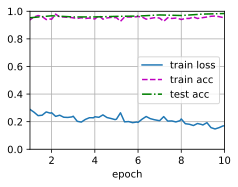

loss 0.170, train acc 0.956, test acc 0.984
98.4 examples/sec on [device(type='cuda', index=0)]


In [14]:
def train_batch(net, X, y, loss, trainer, devices):
    """Train for a minibatch with mutiple GPUs (defined in Chapter 13).

    Defined in :numref:`sec_image_augmentation`"""
    if isinstance(X, list):
        # Required for BERT fine-tuning (to be covered later)
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    y = y.to(devices[0])
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = d2l.accuracy(pred, y)
    return train_loss_sum, train_acc_sum

def evaluate_accuracy_gpu(net, data_iter, device=None):
    """Compute the accuracy for a model on a dataset using a GPU.

    Defined in :numref:`sec_lenet`"""
    if isinstance(net, nn.Module):
        net.eval()  # Set the model to evaluation mode
        if not device:
            device = next(iter(net.parameters())).device
    # No. of correct predictions, no. of predictions
    metric = d2l.Accumulator(2)

    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # Required for BERT Fine-tuning (to be covered later)
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), d2l.size(y))
    return metric[0] / metric[1]

def train(net, train_iter, test_iter, loss, trainer, num_epochs,
               devices=d2l.try_all_gpus()):

    """Train a model with mutiple GPUs (defined in Chapter 13). Defined in :numref:`sec_image_augmentation`"""
    timer, num_batches = d2l.Timer(), len(train_iter)

    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],legend=['train loss', 'train acc', 'test acc'])

    net = nn.DataParallel(net, device_ids=devices).to(devices[0])

    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples,
        # no. of predictions
        metric = d2l.Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch(
                net, features, labels, loss, trainer, devices)
            metric.add(l, acc, labels.shape[0], labels.numel())
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[3],
                              None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    animator.show()
    print(f'loss {metric[0] / metric[2]:.3f}, train acc '
          f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
          f'{str(devices)}')


"""
定义一个训练函数train_fine_tuning，该函数使用微调，因此可以多次调用。
"""
# 如果param_group=True，输出层中的模型参数将使用十倍的学习率
def train_fine_tuning(net, learning_rate, batch_size=32, num_epochs=10,param_group=True):

    train_iter = torch.utils.data.DataLoader(
        torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'),
        transform=train_augs),
        batch_size=batch_size,
        shuffle=True)


    test_iter = torch.utils.data.DataLoader(
        torchvision.datasets.ImageFolder(os.path.join(data_dir, 'test'),
        transform=test_augs),
        batch_size=batch_size)

    print(len(train_iter),len(test_iter))

    devices = d2l.try_all_gpus()

    loss = nn.CrossEntropyLoss(reduction="none")

    if param_group:
        params_1x = [param for name, param in net.named_parameters()
             if name not in ["fc.weight", "fc.bias"]]
        trainer = torch.optim.SGD([{'params': params_1x},
                                   {'params': net.fc.parameters(),
                                    'lr': learning_rate * 10}],
                                lr=learning_rate, weight_decay=0.001)
    else:
        trainer = torch.optim.SGD(net.parameters(),
                                  lr=learning_rate,
                                  weight_decay=0.001)
    train(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

"""
我们使用较小的学习率，通过微调预训练获得的模型参数。
"""
train_fine_tuning(finetune_net,5e-5)

In [36]:
torch.save(finetune_net,'finetune_net.pth')

## 4 使用训练好的模型对每类进行测试

In [37]:
# 载入类别名称 和 ID索引号 的映射字典
idx_to_labels = np.load('idx_to_labels.npy', allow_pickle=True).item()
# 获得类别名称
classes = list(idx_to_labels.values())
print(classes)

['debanbing', 'healthy', 'wenbaoyebanbing', 'xiubing', 'yuanbanbing']


In [38]:
test_imgs.imgs
img_paths = [each[0] for each in test_imgs.imgs]
df = pd.DataFrame()
df['图像路径'] = img_paths
df['标注类别ID'] = test_imgs.targets
df['标注类别名称'] = [idx_to_labels[ID] for ID in test_imgs.targets]
df

,图像路径,标注类别ID,标注类别名称
0,../../data/corn/test/dabanbing/dabanbing (130)...,0,debanbing
1,../../data/corn/test/dabanbing/dabanbing (131)...,0,debanbing
2,../../data/corn/test/dabanbing/dabanbing (132)...,0,debanbing
3,../../data/corn/test/dabanbing/dabanbing (133)...,0,debanbing
4,../../data/corn/test/dabanbing/dabanbing (145)...,0,debanbing
...,...,...,...
482,../../data/corn/test/yuanbanbing/nls_548.jpg,4,yuanbanbing
483,../../data/corn/test/yuanbanbing/nls_549.jpg,4,yuanbanbing
484,../../data/corn/test/yuanbanbing/nls_550.jpg,4,yuanbanbing
485,../../data/corn/test/yuanbanbing/nls_551.jpg,4,yuanbanbing


In [40]:
from tqdm import tqdm
from PIL import Image
import torch.nn.functional as F

"""
测试集每张图像的图像分类预测结果，以及各类别置信度
"""
# 记录 top-n 预测结果
n = 3
device=d2l.try_gpu()
model = torch.load('./finetune_net.pth')
model = model.eval().to(device)

df_pred = pd.DataFrame()
for idx, row in tqdm(df.iterrows()):
    img_path = row['图像路径']
    img_pil = Image.open(img_path).convert('RGB')
    input_img = test_augs(img_pil).unsqueeze(0).to(device) # 预处理
    pred_logits = model(input_img) # 执行前向预测，得到所有类别的 logit 预测分数
    pred_softmax = F.softmax(pred_logits, dim=1) # 对 logit 分数做 softmax 运算

    pred_dict = {}

    top_n = torch.topk(pred_softmax, n) # 取置信度最大的 n 个结果
    pred_ids = top_n[1].cpu().detach().numpy().squeeze() # 解析出类别

    # top-n 预测结果
    for i in range(1, n+1):
        pred_dict['top-{}-预测ID'.format(i)] = pred_ids[i-1]
        pred_dict['top-{}-预测名称'.format(i)] = idx_to_labels[pred_ids[i-1]]
    pred_dict['top-n预测正确'] = row['标注类别ID'] in pred_ids
    # 每个类别的预测置信度
    for idx, each in enumerate(classes):
        pred_dict['{}-预测置信度'.format(each)] = pred_softmax[0][idx].cpu().detach().numpy()

    df_pred = df_pred.append(pred_dict, ignore_index=True)

0it [00:00, ?it/s]/tmp/ipykernel_269160/3958629407.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_pred = df_pred.append(pred_dict, ignore_index=True)
/tmp/ipykernel_269160/3958629407.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_pred = df_pred.append(pred_dict, ignore_index=True)
/tmp/ipykernel_269160/3958629407.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_pred = df_pred.append(pred_dict, ignore_index=True)
/tmp/ipykernel_269160/3958629407.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_pred = df_pred.append(pred_dict, ignore_index=True)
/tmp/ipykernel_269160/3958629407.py:36: FutureWarning: The fra

In [41]:
df_pred

,top-1-预测ID,top-1-预测名称,top-2-预测ID,top-2-预测名称,top-3-预测ID,top-3-预测名称,top-n预测正确,debanbing-预测置信度,healthy-预测置信度,wenbaoyebanbing-预测置信度,xiubing-预测置信度,yuanbanbing-预测置信度
0,0,debanbing,2,wenbaoyebanbing,1,healthy,True,0.8219097,0.020922929,0.12861598,0.019152593,0.009398735
1,0,debanbing,3,xiubing,4,yuanbanbing,True,0.9465281,0.0038634015,0.008663781,0.024734894,0.016209833
2,0,debanbing,4,yuanbanbing,3,xiubing,True,0.74875194,0.059017368,0.02928657,0.06669637,0.09624774
3,0,debanbing,4,yuanbanbing,2,wenbaoyebanbing,True,0.79221505,0.049745973,0.05248355,0.039803203,0.06575216
4,0,debanbing,2,wenbaoyebanbing,3,xiubing,True,0.986555,0.00043740906,0.005097764,0.0043958,0.0035141273
...,...,...,...,...,...,...,...,...,...,...,...,...
482,4,yuanbanbing,2,wenbaoyebanbing,1,healthy,True,0.0036123877,0.015641073,0.023005184,0.0043178094,0.9534236
483,4,yuanbanbing,2,wenbaoyebanbing,1,healthy,True,0.0009714704,0.002545131,0.0060190563,0.00039819913,0.9900662
484,4,yuanbanbing,2,wenbaoyebanbing,1,healthy,True,0.0006318293,0.010679304,0.011282676,0.0007484221,0.97665775
485,4,yuanbanbing,1,healthy,2,wenbaoyebanbing,True,0.0020774493,0.010680865,0.008484157,0.0006063955,0.9781512


In [42]:
"""
拼接AB两张表格
"""
df = pd.concat([df, df_pred], axis=1)
df

,图像路径,标注类别ID,标注类别名称,top-1-预测ID,top-1-预测名称,top-2-预测ID,top-2-预测名称,top-3-预测ID,top-3-预测名称,top-n预测正确,debanbing-预测置信度,healthy-预测置信度,wenbaoyebanbing-预测置信度,xiubing-预测置信度,yuanbanbing-预测置信度
0,../../data/corn/test/dabanbing/dabanbing (130)...,0,debanbing,0,debanbing,2,wenbaoyebanbing,1,healthy,True,0.8219097,0.020922929,0.12861598,0.019152593,0.009398735
1,../../data/corn/test/dabanbing/dabanbing (131)...,0,debanbing,0,debanbing,3,xiubing,4,yuanbanbing,True,0.9465281,0.0038634015,0.008663781,0.024734894,0.016209833
2,../../data/corn/test/dabanbing/dabanbing (132)...,0,debanbing,0,debanbing,4,yuanbanbing,3,xiubing,True,0.74875194,0.059017368,0.02928657,0.06669637,0.09624774
3,../../data/corn/test/dabanbing/dabanbing (133)...,0,debanbing,0,debanbing,4,yuanbanbing,2,wenbaoyebanbing,True,0.79221505,0.049745973,0.05248355,0.039803203,0.06575216
4,../../data/corn/test/dabanbing/dabanbing (145)...,0,debanbing,0,debanbing,2,wenbaoyebanbing,3,xiubing,True,0.986555,0.00043740906,0.005097764,0.0043958,0.0035141273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
482,../../data/corn/test/yuanbanbing/nls_548.jpg,4,yuanbanbing,4,yuanbanbing,2,wenbaoyebanbing,1,healthy,True,0.0036123877,0.015641073,0.023005184,0.0043178094,0.9534236
483,../../data/corn/test/yuanbanbing/nls_549.jpg,4,yuanbanbing,4,yuanbanbing,2,wenbaoyebanbing,1,healthy,True,0.0009714704,0.002545131,0.0060190563,0.00039819913,0.9900662
484,../../data/corn/test/yuanbanbing/nls_550.jpg,4,yuanbanbing,4,yuanbanbing,2,wenbaoyebanbing,1,healthy,True,0.0006318293,0.010679304,0.011282676,0.0007484221,0.97665775
485,../../data/corn/test/yuanbanbing/nls_551.jpg,4,yuanbanbing,4,yuanbanbing,1,healthy,2,wenbaoyebanbing,True,0.0020774493,0.010680865,0.008484157,0.0006063955,0.9781512


In [43]:
"""
导出完整表格
"""
df.to_csv('测试集预测结果.csv', index=False)

"""
载入类别名称和ID
"""
idx_to_labels = np.load('idx_to_labels.npy', allow_pickle=True).item()
# 获得类别名称
classes = list(idx_to_labels.values())
print(classes)

['debanbing', 'healthy', 'wenbaoyebanbing', 'xiubing', 'yuanbanbing']


In [44]:
# 载入测试集预测结果表格
df = pd.read_csv('测试集预测结果.csv')
# 准确率
sum(df['标注类别名称'] == df['top-1-预测名称']) / len(df)

0.9609856262833676

In [45]:
# top-n准确率
sum(df['top-n预测正确']) / len(df)

1.0

In [46]:
from sklearn.metrics import classification_report
"""
各类别其它评估指标

macro avg 宏平均：直接将每一类的评估指标求和取平均（算数平均值）
weighted avg 加权平均：按样本数量（support）加权计算评估指标的平均值
"""
print(classification_report(df['标注类别名称'], df['top-1-预测名称'], target_names=classes))
report = classification_report(df['标注类别名称'], df['top-1-预测名称'], target_names=classes, output_dict=True)
del report['accuracy']
df_report = pd.DataFrame(report).transpose()
df_report

                 precision    recall  f1-score   support

      debanbing       0.97      0.97      0.97       100
        healthy       0.94      0.97      0.95        87
wenbaoyebanbing       0.93      0.92      0.92       100
        xiubing       0.97      0.99      0.98       100
    yuanbanbing       0.99      0.96      0.97       100

       accuracy                           0.96       487
      macro avg       0.96      0.96      0.96       487
   weighted avg       0.96      0.96      0.96       487



,precision,recall,f1-score,support
debanbing,0.970000,0.970000,0.970000,100.0
healthy,0.943820,0.965517,0.954545,87.0
wenbaoyebanbing,0.929293,0.920000,0.924623,100.0
xiubing,0.970588,0.990000,0.980198,100.0
yuanbanbing,0.989691,0.960000,0.974619,100.0
macro avg,0.960678,0.961103,0.960797,487.0
weighted avg,0.961128,0.960986,0.960964,487.0


## 5 各类别准确率

In [47]:
"""
各类别准确率
"""
accuracy_list = []
for fruit in tqdm(classes):
    df_temp = df[df['标注类别名称']==fruit]
    accuracy = sum(df_temp['标注类别名称'] == df_temp['top-1-预测名称']) / len(df_temp)
    accuracy_list.append(accuracy)

# 计算 宏平均准确率 和 加权平均准确率
acc_macro = np.mean(accuracy_list)
acc_weighted = sum(accuracy_list * df_report.iloc[:-2]['support'] / len(df))

accuracy_list.append(acc_macro)
accuracy_list.append(acc_weighted)

df_report['accuracy'] = accuracy_list

df_report

100%|██████████| 5/5 [00:00<00:00, 2353.18it/s]


,precision,recall,f1-score,support,accuracy
debanbing,0.970000,0.970000,0.970000,100.0,0.970000
healthy,0.943820,0.965517,0.954545,87.0,0.965517
wenbaoyebanbing,0.929293,0.920000,0.924623,100.0,0.920000
xiubing,0.970588,0.990000,0.980198,100.0,0.990000
yuanbanbing,0.989691,0.960000,0.974619,100.0,0.960000
macro avg,0.960678,0.961103,0.960797,487.0,0.961103
weighted avg,0.961128,0.960986,0.960964,487.0,0.960986


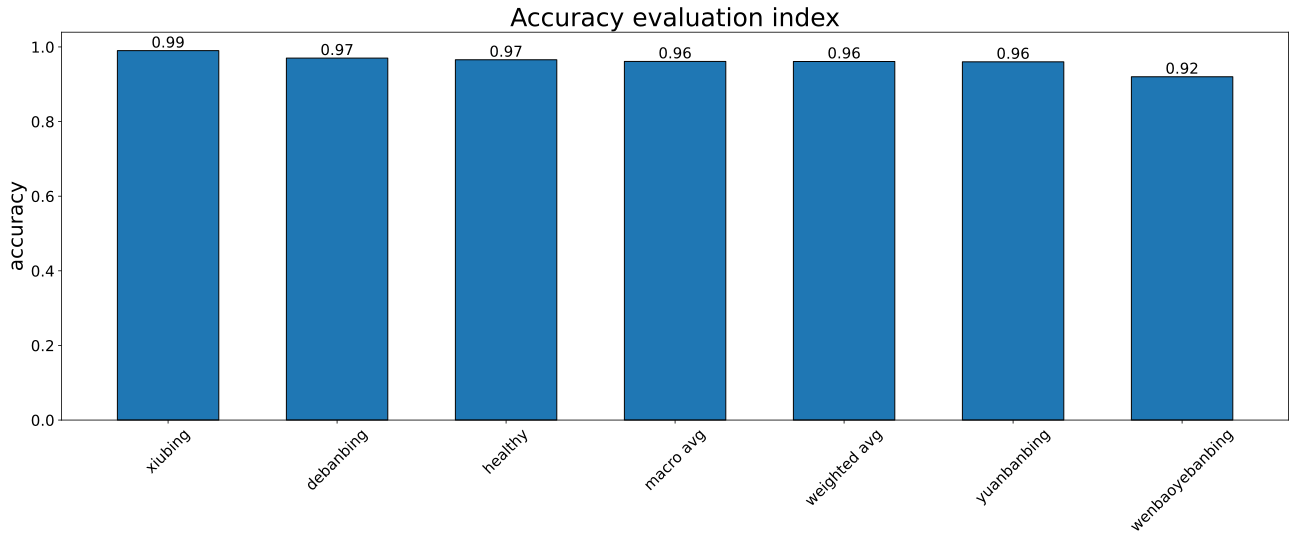

In [56]:
"""
保存各类别准确率评估指标
"""
df_report.to_csv('./各类别准确率评估指标.csv', index_label='类别')

In [ ]:
"""
绘制柱状图
"""
df = pd.read_csv('各类别准确率评估指标.csv')
feature = 'accuracy'  # 选择评估指标
df_plot = df.sort_values(by=feature, ascending=False)

plt.figure(figsize=(22, 7))

x = df_plot['类别']
y = df_plot[feature]

ax = plt.bar(x, y, width=0.6, facecolor='#1f77b4', edgecolor='k')
plt.bar_label(ax, fmt='%.2f', fontsize=15) # 置信度数值

plt.xticks(rotation=45)
plt.tick_params(labelsize=15)
# plt.xlabel('类别', fontsize=20)
plt.ylabel(feature, fontsize=20)
plt.title('Accuracy evaluation index', fontsize=25)

plt.savefig('各类别准确率评估指标柱状图-{}.pdf'.format(feature), dpi=120, bbox_inches='tight')

plt.show()

## 6 生成混淆矩阵

In [50]:
"""
载入测试集预测结果表格
"""
df = pd.read_csv('测试集预测结果.csv')
df.head()

,图像路径,标注类别ID,标注类别名称,top-1-预测ID,top-1-预测名称,top-2-预测ID,top-2-预测名称,top-3-预测ID,top-3-预测名称,top-n预测正确,debanbing-预测置信度,healthy-预测置信度,wenbaoyebanbing-预测置信度,xiubing-预测置信度,yuanbanbing-预测置信度
0,../../data/corn/test/dabanbing/dabanbing (130)...,0,debanbing,0,debanbing,2,wenbaoyebanbing,1,healthy,True,0.821910,0.020923,0.128616,0.019153,0.009399
1,../../data/corn/test/dabanbing/dabanbing (131)...,0,debanbing,0,debanbing,3,xiubing,4,yuanbanbing,True,0.946528,0.003863,0.008664,0.024735,0.016210
2,../../data/corn/test/dabanbing/dabanbing (132)...,0,debanbing,0,debanbing,4,yuanbanbing,3,xiubing,True,0.748752,0.059017,0.029287,0.066696,0.096248
3,../../data/corn/test/dabanbing/dabanbing (133)...,0,debanbing,0,debanbing,4,yuanbanbing,2,wenbaoyebanbing,True,0.792215,0.049746,0.052484,0.039803,0.065752
4,../../data/corn/test/dabanbing/dabanbing (145)...,0,debanbing,0,debanbing,2,wenbaoyebanbing,3,xiubing,True,0.986555,0.000437,0.005098,0.004396,0.003514


In [51]:

"""
生成混淆矩阵
"""

confusion_matrix_model = confusion_matrix(df['标注类别名称'], df['top-1-预测名称'])
print(confusion_matrix_model.shape)
confusion_matrix_model

(5, 5)


array([[97,  0,  0,  3,  0],
       [ 0, 84,  3,  0,  0],
       [ 2,  5, 92,  0,  1],
       [ 1,  0,  0, 99,  0],
       [ 0,  0,  4,  0, 96]])

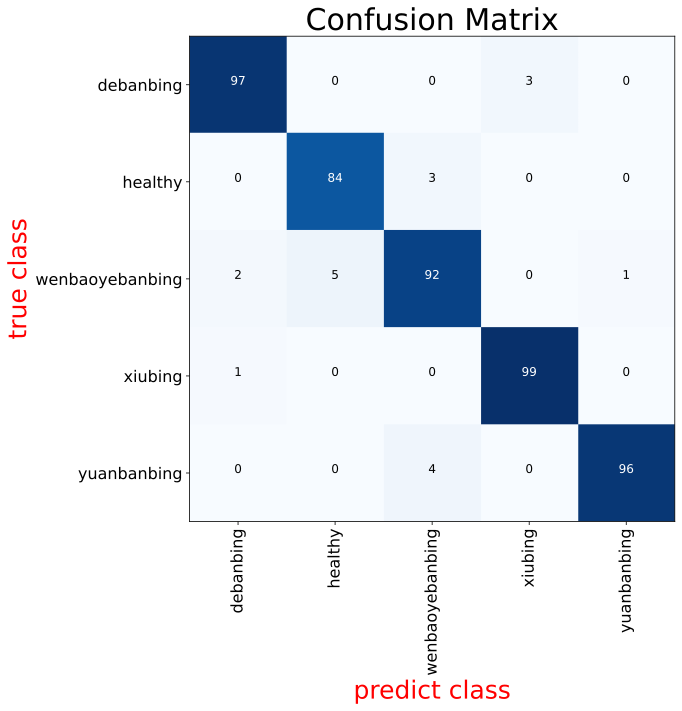

In [54]:


"""
可视化混淆矩阵
"""
import itertools
def cnf_matrix_plotter(cm, classes, cmap=plt.cm.Blues):
    """
    传入混淆矩阵和标签名称列表，绘制混淆矩阵
    """
    plt.figure(figsize=(10, 10))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    # plt.colorbar() # 色条
    tick_marks = np.arange(len(classes))

    plt.title('Confusion Matrix', fontsize=30)
    plt.xlabel('predict class', fontsize=25, c='r')
    plt.ylabel('true class', fontsize=25, c='r')
    plt.tick_params(labelsize=16) # 设置类别文字大小
    plt.xticks(tick_marks, classes, rotation=90) # 横轴文字旋转
    plt.yticks(tick_marks, classes)

    # 写数字
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > threshold else "black",
                 fontsize=12)

    plt.tight_layout()

    plt.savefig('混淆矩阵.pdf', dpi=300) # 保存图像
    plt.show()
cnf_matrix_plotter(confusion_matrix_model, classes, cmap='Blues')

## 7 绘制所有类别的ROC曲线

In [7]:
idx_to_labels = np.load('idx_to_labels.npy', allow_pickle=True).item()
# 获得类别名称
classes = list(idx_to_labels.values())
print(classes)

['debanbing', 'healthy', 'wenbaoyebanbing', 'xiubing', 'yuanbanbing']


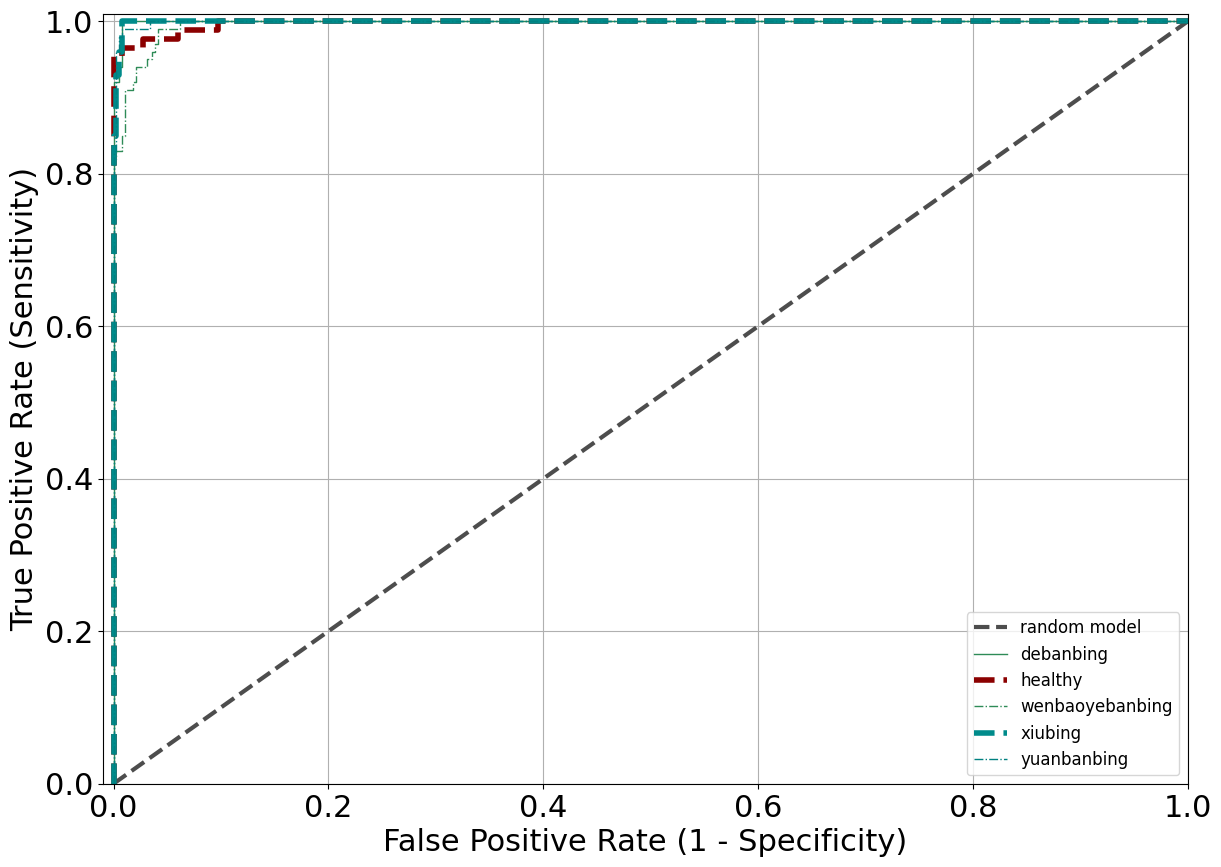

In [9]:

random.seed(124)
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 'black', 'indianred', 'brown', 'firebrick', 'maroon', 'darkred', 'red', 'sienna', 'chocolate', 'yellow', 'olivedrab', 'yellowgreen', 'darkolivegreen', 'forestgreen', 'limegreen', 'darkgreen', 'green', 'lime', 'seagreen', 'mediumseagreen', 'darkslategray', 'darkslategrey', 'teal', 'darkcyan', 'dodgerblue', 'navy', 'darkblue', 'mediumblue', 'blue', 'slateblue', 'darkslateblue', 'mediumslateblue', 'mediumpurple', 'rebeccapurple', 'blueviolet', 'indigo', 'darkorchid', 'darkviolet', 'mediumorchid', 'purple', 'darkmagenta', 'fuchsia', 'magenta', 'orchid', 'mediumvioletred', 'deeppink', 'hotpink']
markers = [".",",","o","v","^","<",">","1","2","3","4","8","s","p","P","*","h","H","+","x","X","D","d","|","_",0,1,2,3,4,5,6,7,8,9,10,11]
linestyle = ['--', '-.', '-']

def get_line_arg():
    '''
    随机产生一种绘图线型
    '''
    line_arg = {}
    line_arg['color'] = random.choice(colors)
    # line_arg['marker'] = random.choice(markers)
    line_arg['linestyle'] = random.choice(linestyle)
    line_arg['linewidth'] = random.randint(1, 4)
    # line_arg['markersize'] = random.randint(3, 5)
    return line_arg

plt.figure(figsize=(14, 10))
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.plot([0, 1], [0, 1],ls="--", c='.3', linewidth=3, label='random model')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.rcParams['font.size'] = 22
plt.grid(True)

auc_list = []
df = pd.read_csv('测试集预测结果.csv')
for each_class in classes:
    y_test = list((df['标注类别名称'] == each_class))
    y_score = list(df['{}-预测置信度'.format(each_class)])
    fpr, tpr, threshold = roc_curve(y_test, y_score)
    plt.plot(fpr, tpr, **get_line_arg(), label=each_class)
    plt.legend()
    auc_list.append(auc(fpr, tpr))

plt.legend(loc='best', fontsize=12)
plt.savefig('各类别ROC曲线.pdf', dpi=120, bbox_inches='tight')
plt.show()

In [10]:
"""
将AUC增加至各类别准确率评估指标表格中
"""
df_report = pd.read_csv('各类别准确率评估指标.csv')

# 计算 AUC值 的 宏平均 和 加权平均
macro_avg_auc = np.mean(auc_list)
weighted_avg_auc = sum(auc_list * df_report.iloc[:-2]['support'] / len(df))

auc_list.append(macro_avg_auc)
auc_list.append(weighted_avg_auc)

df_report['AUC'] = auc_list

df_report.to_csv('各类别准确率评估指标.csv', index=False)

## 8 绘制PR曲线

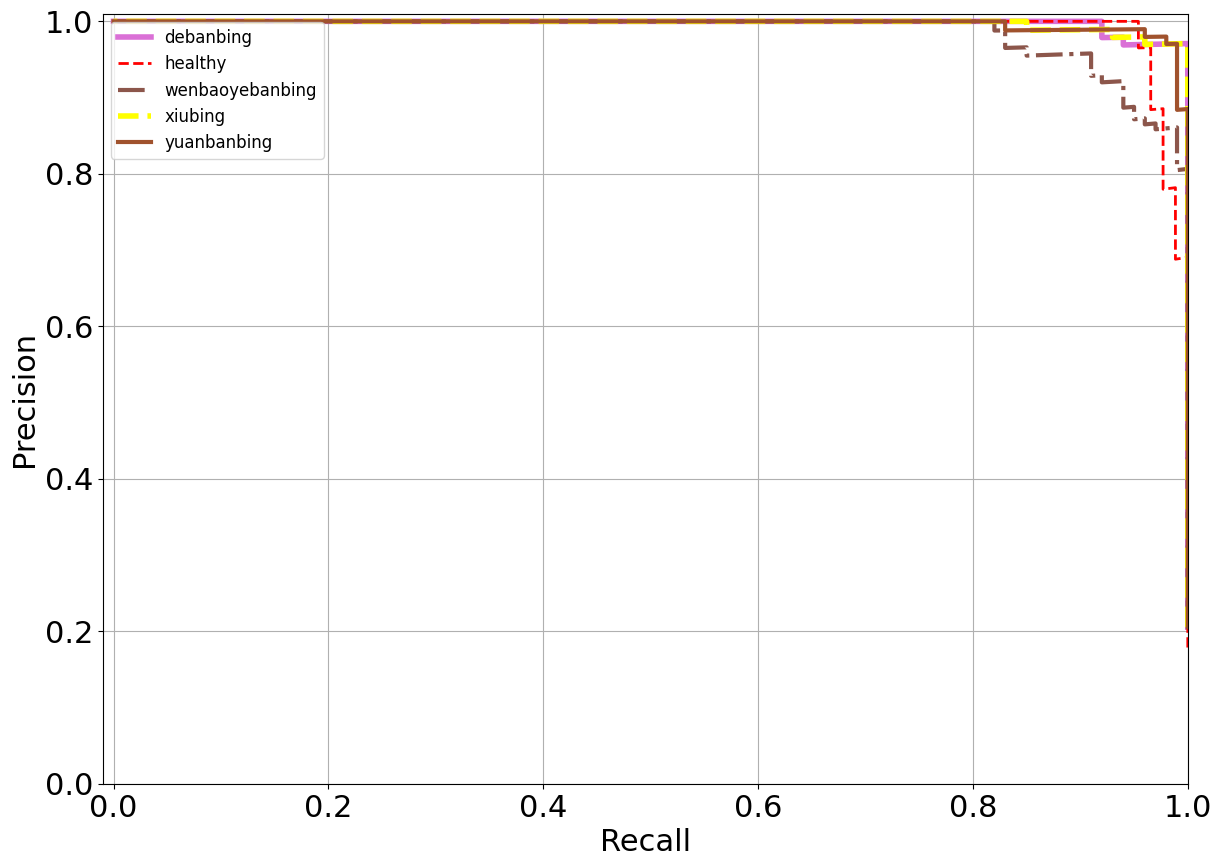

In [11]:
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(14, 10))
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
# plt.plot([0, 1], [0, 1],ls="--", c='.3', linewidth=3, label='随机模型')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.rcParams['font.size'] = 22
plt.grid(True)

ap_list = []
for each_class in classes:
    y_test = list((df['标注类别名称'] == each_class))
    y_score = list(df['{}-预测置信度'.format(each_class)])
    precision, recall, thresholds = precision_recall_curve(y_test, y_score)
    AP = average_precision_score(y_test, y_score, average='weighted')
    plt.plot(recall, precision, **get_line_arg(), label=each_class)
    plt.legend()
    ap_list.append(AP)

plt.legend(loc='best', fontsize=12)
plt.savefig('各类别PR曲线.pdf', dpi=120, bbox_inches='tight')
plt.show()